# BLAES Units Control Analyses

This notebook contains code for running a series of control analyses related to the BLAES Units project.

1. **Dropout Analysis**: to account for change in FR attributable to inability to detect because of stim artifact.
2. **Modulation Sensitivity Analysis**: X. 

---

> *Contact: Justin Campbell (justin.campbell@hsc.utah.edu)*  
> *Version: 5/21/2025*

## 1. Import Libraries

In [1]:
import os
import re
import glob
import datetime
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from scipy.stats import wilcoxon, ranksums, norm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'
# %config InlineBackend.figure_format='svg'

## 2. Set Paths & Parameters

In [2]:
# Params
fs = 30000
fr_thresh = 0.1
drop_wins = np.arange(0, 0.065, 0.005) # 0-60 ms, 5 ms bins
export = True

# Define paths
results_path = '/Users/justincampbell/Library/CloudStorage/GoogleDrive-u0815766@gcloud.utah.edu/My Drive/Research Projects/BLAESUnits/Results/'

# Get list of sessions
pIDs = os.listdir(results_path)
pIDs = [pID for pID in pIDs if re.search(r'\d+$', pID)]

In [3]:
# Load group data
allSpikeInfo = pd.read_csv(os.path.join(results_path, 'Group', 'AllSpikeInfo.csv'), index_col = 0)
allSpikeInfo = allSpikeInfo[['Trial', 'Unit', 'pID', 'StimLat', 'UnitLat', 'Ipsilateral', 'Region']]

# Load spike stats
statsDF = pd.read_csv(os.path.join(results_path, 'Group', 'SpikeStats.csv'), index_col=0)

# Bad units
unitsToExclude = pd.read_csv('/Users/justincampbell/Library/CloudStorage/GoogleDrive-u0815766@gcloud.utah.edu/My Drive/Research Projects/BLAESUnits/UnitsToExclude.csv')

In [4]:
# Toggle analyses
run_dropout = False

## 3. Dropout Analysis
It may be difficult to detect spikes during the periods in which stimulation is being delivered (e.g., amplifier may be saturated, contaminated by stimulation artifact). This control analysis repeates the pre-/post- and pre-/during-stim trial FR contrasts, but removes different segments of data from each epoch.

In [5]:
def applyDropout(pID, drop_win = 0.025, num_bursts = 8):
    '''
    Plot unit raster for peri-stimulation epochs.
    
    Arguments:
        pID (str): patient ID
        drop_win (float): dropout window duration (in seconds) [default = 0.025]
        num_bursts (int): number of stimulationbursts [default = 8]
        
    Returns:
        spikesDF (pd.DataFrame): DataFrame containing spike counts for each epoch
    '''
    
    # Load events and epochs
    events = pd.read_csv(os.path.join(results_path, pID, 'Events.csv'), index_col = 0)
    PSEpochs_stim = pd.read_csv(os.path.join(results_path, pID, 'StimEpochs.csv'), index_col = 0)
    PSEpochs_nostim = pd.read_csv(os.path.join(results_path, pID, 'NoStimEpochs.csv'), index_col = 0)
    
    # Combine epochs
    PSEpochs = pd.concat([PSEpochs_stim, PSEpochs_nostim], axis = 1)
    PSEpochs.columns = np.arange(PSEpochs.shape[1])
    PSEpochs = PSEpochs.reset_index(drop = True)
    epochsID = np.zeros(PSEpochs.shape[1])
    epochsID[:PSEpochs_stim.shape[1]] = 1
    epochsID = np.where(epochsID == 1, 'Stim', 'No-Stim')

    # # Create dropout windows
    burst_onsets = fs * np.arange(0, 1.125, .125)
    burst_offsets = burst_onsets + (drop_win * fs)

    # Loop through channels
    spikeDFHolder = []
    for chan in events['Channel'].unique():
        chanDF = events[events['Channel'] == chan]
        # Loop through units
        for unit in chanDF['Unit'].unique():
            unitDF = chanDF[chanDF['Unit'] == unit]
            unitSpikes = unitDF['TimeStamps']
            
            # Initialize spike count dictionaries
            preISISpikes = {}
            imgOnsetSpikes = {}
            preSpikes = {}
            duringSpikes = {}
            postSpikes = {}
            
            # Loop through epochs/trials
            for epoch in range(PSEpochs.shape[1]):
                epochStart = PSEpochs.iloc[0, epoch]
                epochImgOnset = PSEpochs.iloc[0, epoch] + fs
                epochStimOnset = PSEpochs.iloc[0, epoch] + (4 * fs)
                epochStimOffset = PSEpochs.iloc[-1, epoch] - fs
                epochEnd = PSEpochs.iloc[-1, epoch]
                epochBurstOnsets = epochStimOnset + burst_onsets
                epochBurstOffsets = epochStimOnset + burst_offsets
                
                # Add pseudo-onsets/offsets for pre- and post-stim windows
                epochBurstOnsets = np.tile(epochBurstOnsets, 3)
                epochBurstOnsets[:num_bursts] = epochBurstOnsets[:num_bursts] - (4*fs)
                epochBurstOnsets[-num_bursts:] = epochBurstOnsets[-num_bursts:] + fs
                
                epochBurstOffsets = np.tile(epochBurstOffsets, 3)
                epochBurstOffsets[:num_bursts] = epochBurstOffsets[:num_bursts] - (4*fs)
                epochBurstOffsets[-num_bursts:] = epochBurstOffsets[-num_bursts:] + fs
                
                # Get list of samples in dropout windows
                drop_samples = []
                for i in range(len(epochBurstOnsets)):
                    drop_samples.append(np.arange(epochBurstOnsets[i], epochBurstOffsets[i], 1))
                drop_samples = np.concatenate(drop_samples)

                # Remove epochSpikes with values that fall within drop_samples
                epochSpikes = unitSpikes[(unitSpikes > epochStart) & (unitSpikes < epochEnd)]
                epochSpikes = epochSpikes[~np.isin(epochSpikes, drop_samples)]
                
                # Initialize spike count variables
                preISICounts = 0
                imgOnsetCounts = 0
                preCount = 0
                duringCount = 0
                postCount = 0
                
                for spike in epochSpikes:
                    if spike < epochImgOnset:
                        preISICounts += 1
                    elif spike >= epochImgOnset and spike < (epochImgOnset + fs):
                        imgOnsetCounts += 1
                    elif spike >= (epochStimOnset - fs) and spike < epochStimOnset:
                        preCount += 1
                    elif spike >= epochStimOnset and spike < epochStimOffset:
                        duringCount += 1
                    elif spike >= epochStimOffset:
                        postCount += 1
                            
                # Update dictionaries
                preISISpikes[epoch] = preISICounts
                imgOnsetSpikes[epoch] = imgOnsetCounts
                preSpikes[epoch] = preCount
                duringSpikes[epoch] = duringCount
                postSpikes[epoch] = postCount
                
            # Convert to DataFrame
            unitSpikeDF = pd.DataFrame([preISISpikes, imgOnsetSpikes, preSpikes, duringSpikes, postSpikes]).T
            unitSpikeDF.columns = ['ISI', 'ImgOnset', 'Pre', 'During', 'Post']
            unitSpikeDF['Trial'] = np.arange(1, unitSpikeDF.shape[0] + 1)
            unitSpikeDF['Unit'] = chan + '-' + str(unit)
            unitSpikeDF['pID'] = pID
            unitSpikeDF['Condition'] = epochsID
            
            # Validity check
            if unitSpikeDF['ISI'].mean(skipna = True) >= fr_thresh:
                unitSpikeDF['Valid'] = True
            else:
                unitSpikeDF['Valid'] = False
                
            # Append to list
            spikeDFHolder.append(unitSpikeDF)

    dropoutDF = pd.concat(spikeDFHolder)
    dropoutDF = dropoutDF.reset_index(drop = True)
    
    return dropoutDF

In [6]:
def runFRContrast(dropoutCounts):
    '''
    This function runs a Wilcoxon signed-rank test on the firing rates of each unit in three contrasts: ISI vs. Img Onset, ISI vs. During-Stim, and ISI vs. Post-Stim. It also runs permutation testing to determine whether the observed test statistic is in the 5% of most extreme values in the permutation distribution (p < 0.05).
    
    Inputs:
    - dropoutCounts (DataFrame): A DataFrame with spike counts for each unit in each epoch of each trial.
    
    Outputs:
    - statsDF (DataFrame): A DataFrame with the results of the statistical tests.
    '''
    
    # Holders for unit characteristics
    unitLabels = []
    pIDLabels = []
    validity = []
    laterality = []
    regions = []
    FR_ISI = []
    FR_Img = []
    FR_stim_During = []
    FR_nostim_During = []
    FR_stim_Post = []
    FR_nostim_Post = []
    
    # Holders for empirical Wilcoxon stat
    stat_Img = []
    stat_stim_During = []
    stat_nostim_During = []
    stat_stim_Post = []
    stat_nostim_Post = []
    
    # Holders for empirical Wilcoxon p-value
    p_Img = []
    p_stim_During = []
    p_nostim_During = []
    p_stim_Post = []
    p_nostim_Post = []
    
    # Holders for distribution of permuted Wilcoxon stats
    statPerm_Img = []
    statPerm_stim_During = []
    statPerm_nostim_During = []
    statPerm_stim_Post = []
    statPerm_nostim_Post = []
    
    # Holders for p-value derived from permutation testing
    pPerm_Img = []
    pPerm_stim_During = []
    pPerm_nostim_During = []
    pPerm_stim_Post = []
    pPerm_nostim_Post = []

    # Holders for significance testing (True if p < 0.05)
    res_Img = []
    res_stim_During = []
    res_nostim_During = []
    res_stim_Post = []
    res_nostim_Post = []
    
    # Permutation params
    nPerms = 1000
    np.random.seed(0)
    
    # Loop through each session
    for pID in dropoutCounts['pID'].unique():
        pIDSpikes = dropoutCounts[dropoutCounts['pID'] == pID]
        
        # Loop through each unit
        for unit in pIDSpikes['Unit'].unique():
            unitDF = pIDSpikes[pIDSpikes['Unit'] == unit]
            
            # Loop through contrasts
            for i in range(5):
                # Determine condition
                if i == 0:
                    condition = 'Both'
                    contrastDF = unitDF.copy()
                elif (i == 1) or (i == 3):
                    condition = 'Stim'
                    contrastDF = unitDF[unitDF['Condition'] == 'Stim'].copy()
                elif (i == 2) or (i == 4):
                    condition = 'No-Stim'
                    contrastDF = unitDF[unitDF['Condition'] == 'No-Stim'].copy()
                    
                # Determine contrast
                if i == 0:
                    contrast = 'ImgOnset'
                elif (i == 1) or (i == 2):
                    contrast = 'During'
                elif (i == 3) or (i == 4):
                    contrast = 'Post'
            
                # Run stats on valid units
                if contrastDF['Valid'].iloc[0] == True:
                    try:
                        stat, p = wilcoxon(contrastDF[contrast], contrastDF['ISI'])
                    except:
                        stat = np.nan
                        p = np.nan
                        
                    # Permutation testing
                    statPerms = []
                    for i in range(nPerms):
                        permDF = contrastDF[['ISI', contrast]].copy().melt(var_name = 'Epoch', value_name = 'Spike')
                        epochLabels = permDF['Epoch']
                        epochLabels = np.random.permutation(epochLabels)
                        permDF['Epoch'] = epochLabels
                        isiSpikes = permDF[permDF['Epoch'] == 'ISI']['Spike']
                        contrastSpikes = permDF[permDF['Epoch'] == contrast]['Spike']
                        statPerm, _ = wilcoxon(contrastSpikes.values, isiSpikes.values)
                        statPerms.append(statPerm)
                        
                    # Compute p-values using z-score method(from permutation distribution)
                    zContrast = (stat - np.mean(statPerms)) / np.std(statPerms)
                    pPerm = norm.sf(abs(zContrast)) * 2
                    if pPerm < 0.05:
                        resPerm = True
                    else:
                        resPerm = False
                        
                # If unit is invalid         
                else:
                    stat = np.nan
                    p = np.nan
                    pPerm = np.nan
                    resPerm = np.nan
                    statPerms = np.nan
                    
                # Append contrast statistics
                if contrast == 'ImgOnset':
                    stat_Img.append(stat)
                    p_Img.append(p)
                    statPerm_Img.append(statPerms)
                    pPerm_Img.append(pPerm)
                    res_Img.append(resPerm)
                elif (condition == 'Stim') and (contrast == 'During'):
                    stat_stim_During.append(stat)
                    p_stim_During.append(p)
                    statPerm_stim_During.append(statPerms)
                    pPerm_stim_During.append(pPerm)
                    res_stim_During.append(resPerm)
                elif (condition == 'No-Stim') and (contrast == 'During'):
                    stat_nostim_During.append(stat)
                    p_nostim_During.append(p)
                    statPerm_nostim_During.append(statPerms)
                    pPerm_nostim_During.append(pPerm)
                    res_nostim_During.append(resPerm)
                elif (condition == 'Stim') and (contrast == 'Post'):
                    stat_stim_Post.append(stat)
                    p_stim_Post.append(p)
                    statPerm_stim_Post.append(statPerms)
                    pPerm_stim_Post.append(pPerm)
                    res_stim_Post.append(resPerm)
                elif (condition == 'No-Stim') and (contrast == 'Post'):
                    stat_nostim_Post.append(stat)
                    p_nostim_Post.append(p)
                    statPerm_nostim_Post.append(statPerms)
                    pPerm_nostim_Post.append(pPerm)
                    res_nostim_Post.append(resPerm)
                
            # Append unit characteristics
            unitLabels.append(unit)
            pIDLabels.append(pID)
            validity.append(unitDF['Valid'].iloc[0])
            laterality.append(unitDF['Ipsilateral'].iloc[0])
            regions.append(unitDF['Region'].iloc[0])
            FR_ISI.append(unitDF['ISI'].mean())
            FR_Img.append(unitDF['ImgOnset'].mean())
            FR_stim_During.append(unitDF[unitDF['Condition'] == 'Stim']['During'].mean())
            FR_nostim_During.append(unitDF[unitDF['Condition'] == 'No-Stim']['During'].mean())
            FR_stim_Post.append(unitDF[unitDF['Condition'] == 'Stim']['Post'].mean())
            FR_nostim_Post.append(unitDF[unitDF['Condition'] == 'No-Stim']['Post'].mean())
            
    # Construct dataframe
    statsDF = pd.DataFrame({'pID': pIDLabels, 
                            'Unit': unitLabels, 
                            'Region': regions, 
                            'Ipsilateral': laterality, 
                            'Valid': validity, 
                            'FR_ISI': FR_ISI, 
                            'FR_Img': FR_Img, 
                            'FR_Stim_During': FR_stim_During, 
                            'FR_NoStim_During': FR_nostim_During, 
                            'FR_Stim_Post': FR_stim_Post, 
                            'FR_NoStim_Post': FR_nostim_Post, 
                            'Stat_Img': stat_Img, 
                            'Stat_Stim_During': stat_stim_During, 
                            'Stat_NoStim_During': stat_nostim_During,  
                            'Stat_Stim_Post': stat_stim_Post, 
                            'Stat_NoStim_Post': stat_nostim_Post,
                            'p_Img': p_Img,
                            'p_Stim_During': p_stim_During, 
                            'p_NoStim_During': p_nostim_During,
                            'p_Stim_Post': p_stim_Post, 
                            'p_NoStim_Post': p_nostim_Post,
                            'StatPerm_Img': statPerm_Img, 
                            'StatPerm_Stim_During': statPerm_stim_During, 
                            'StatPerm_NoStim_During': statPerm_nostim_During,
                            'StatPerm_Stim_Post': statPerm_stim_Post, 
                            'StatPerm_NoStim_Post': statPerm_nostim_Post,
                            'pPerm_Img': pPerm_Img, 
                            'pPerm_Stim_During': pPerm_stim_During, 
                            'pPerm_NoStim_During': pPerm_nostim_During,
                            'pPerm_Stim_Post': pPerm_stim_Post, 
                            'pPerm_NoStim_Post': pPerm_nostim_Post,
                            'SigPerm_Img': res_Img, 
                            'SigPerm_Stim_During': res_stim_During, 
                            'SigPerm_NoStim_During': res_nostim_During,
                            'SigPerm_Stim_Post': res_stim_Post, 
                            'SigPerm_NoStim_Post': res_nostim_Post})

    # Add column for significant results w/ permutation testing
    statsDF['StimSig'] = (statsDF['SigPerm_Stim_During'] == True) | (statsDF['SigPerm_Stim_Post'] == True)
    statsDF['NoStimSig'] = (statsDF['SigPerm_NoStim_During'] == True) | (statsDF['SigPerm_NoStim_Post'] == True)
    statsDF['ImgSig'] = (statsDF['SigPerm_Img'] == True)
    
    return statsDF

In [7]:
if run_dropout:
    # Reference results against group stats
    statsDF = pd.read_csv(os.path.join(results_path, 'Group', 'SpikeStats.csv'), index_col = 0)

    # Apply dropout analysis across different dropout windows
    dropoutStatsDFs = []
    for x in drop_wins:
        print('Running dropout analysis for: %.1fms' % (x * 1000))
        dropoutCounts = []
        for pID in pIDs:
            dropoutDF = applyDropout(pID, drop_win = x)
            dropoutCounts.append(dropoutDF)
        dropoutCounts = pd.concat(dropoutCounts)
        dropoutCounts = pd.merge(dropoutCounts, allSpikeInfo[['pID', 'Unit', 'Trial', 'StimLat', 'UnitLat', 'Region', 'Ipsilateral']], on = ['pID', 'Unit', 'Trial'], how = 'left')
        dropoutCounts['Dropout_Win'] = x
        for index, row in unitsToExclude.iterrows():
            dropoutCounts = dropoutCounts[~((dropoutCounts['pID'] == row['pID']) & (dropoutCounts['Unit'] == row['Unit']))]    
        dropoutStatsDFs.append(runFRContrast(dropoutCounts))
        
    # Create holders
    totalValid = []
    totalStimSig = []
    totalNoStimSig = []
    percentValid = []
    percentStimSig = []
    percentNoStimSig = []

    # Summarize results
    for df in dropoutStatsDFs:
        # Remove rows from df if unit and pID are in unitsToExclude
        for index, row in unitsToExclude.iterrows():
            df = df[~((df['pID'] == row['pID']) & (df['Unit'] == row['Unit']))]

        dfValid = df[df['Valid'] == True]
        n_valid = dfValid.shape[0]
        n_stimsig = dfValid['StimSig'].sum()
        n_nostimsig = dfValid['NoStimSig'].sum()
        totalValid.append(n_valid)
        totalStimSig.append(n_stimsig)
        totalNoStimSig.append(n_nostimsig)
        percentValid.append((n_valid / df.shape[0]) * 100)
        percentStimSig.append((n_stimsig / df[df['Valid'] == True].shape[0]) * 100)
        percentNoStimSig.append((n_nostimsig / df[df['Valid'] == True].shape[0]) * 100)

    dropoutSummary = pd.DataFrame({'DropWin': drop_wins, 'TotalValid': totalValid, 'TotalStimSig': totalStimSig, 'TotalNoStimSig': totalNoStimSig, 'PercentValid': percentValid, 'PercentStimSig': percentStimSig, 'PercentNoStimSig': percentNoStimSig})

    # Export results
    dropoutSummary.to_csv(os.path.join(results_path, 'Group', 'DropoutAnalysisSummary.csv'))
    pd.concat(dropoutStatsDFs).to_csv(os.path.join(results_path, 'Group', 'DropoutAnalysisStats.csv'))

In [93]:
dropoutSummary = pd.read_csv(os.path.join(results_path, 'Group', 'DropoutAnalysisSummary.csv'), index_col = 0)
dropoutSummary

,DropWin,TotalValid,TotalStimSig,TotalNoStimSig,PercentValid,PercentStimSig,PercentNoStimSig
0,0.000,156,47,24,76.847291,30.128205,15.384615
1,0.005,156,44,25,76.847291,28.205128,16.025641
2,0.010,155,45,27,76.354680,29.032258,17.419355
3,0.015,154,44,28,75.862069,28.571429,18.181818
4,0.020,153,44,25,75.369458,28.758170,16.339869
5,0.025,150,42,22,73.891626,28.000000,14.666667
6,0.030,150,42,19,73.891626,28.000000,12.666667
7,0.035,146,46,22,71.921182,31.506849,15.068493
8,0.040,146,39,24,71.921182,26.712329,16.438356
9,0.045,144,36,26,70.935961,25.000000,18.055556


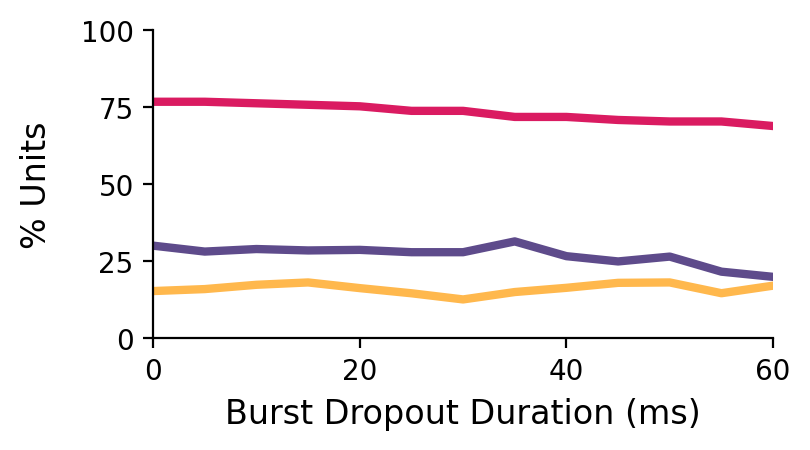

In [94]:
dropoutSummary['DropWin'] = dropoutSummary['DropWin'] * 1000

fig, ax = plt.subplots(1, 1, figsize = (4, 2))
plt.subplots_adjust(wspace = 0.3)
plotPal = ['#da1b61', '#5e4b8b', '#ffb84d']
lw = 3

# Plotting
sns.lineplot(data = dropoutSummary, x = 'DropWin', y = 'PercentValid', color = plotPal[0], lw = lw, ax = ax, label=None)
sns.lineplot(data = dropoutSummary, x = 'DropWin', y = 'PercentStimSig', color = plotPal[1], lw = lw, ax = ax, label=None)
sns.lineplot(data = dropoutSummary, x = 'DropWin', y = 'PercentNoStimSig', color = plotPal[2], lw = lw, ax = ax, label=None)

# Figure aeshtetics
ax.set_xticks(np.arange(0, 61, 20))
ax.set_xlim(0, 60)
ax.set_xlabel('Burst Dropout Duration (ms)', fontsize = 'large')
ax.set_ylabel('% Units', fontsize = 'large', labelpad = 10)
ax.set_yticks(np.arange(0, 101, 25))
ax.set_ylim([0, 100])
sns.despine(top = True, right = True)

# Export & Display
if export:
    plt.savefig((os.path.join(results_path, 'Group', 'Figures', 'DropoutAnalysis.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()

## 4. Modulation Sensitivity Analysis
There are two factors at play which may affect the tendency to detect modulated units. First, it may be easier for units with lower trialwise spike to have a significant Wilcoxon result (easier to swap ranks with small changes). Second, units with greater baseline FR appear to be those modulated by stim (less of a floor effect). Below, I've performed a simulation to compare the modulation detection probability across a range of baseline FRs and trialwise FR differences using synthetic data

In [11]:
# create 10 log-spaced bins numbers from 0.1 to 5
rates = np.logspace(np.log10(0.1), np.log10(5), 10)
effect_sizes = np.logspace(np.log10(0.1), np.log10(2), 10)

In [ ]:
# 1) SIMULATE
n_trials = 80
n_sims   = 500    # you can increase for smoother contours
baseline_rates = np.logspace(np.log10(0.1), np.log10(5), 20)
effect_sizes = np.logspace(np.log10(0.1), np.log10(0.9), 20)

sim_data = []
for lam in baseline_rates:
    for delta in effect_sizes:
        sig_count = 0
        for _ in range(n_sims):
            pre  = np.random.poisson(lam, n_trials)
            post = np.random.poisson(lam + delta, n_trials)
            _, pval = wilcoxon(pre, post)
            if pval < 0.05:
                sig_count += 1
        power = sig_count / n_sims
        sim_data.append((lam, delta, power))

df_sim = pd.DataFrame(sim_data, columns=['lambda','delta','power'])

# 2) FIT LOGISTIC REGRESSION ON SIMULATED BINARY OUTCOME
#    We need binary examples, so expand each (lam, delta, power) into n_sims rows:
rows = []
for lam, delta, power in sim_data:
    # replicate trials: power fraction labeled 1, rest 0
    n1 = int(round(power * 100))
    n0 = 100 - n1
    rows += [(lam, delta, 1)] * n1 + [(lam, delta, 0)] * n0
df_lr = pd.DataFrame(rows, columns=['lambda','delta','sig'])
X = df_lr[['lambda','delta']]
y = df_lr['sig']

clf = LogisticRegression(solver='lbfgs', max_iter=1000)
clf.fit(X, y)

# 3) MAKE CONTOUR GRID
lam_grid, delta_grid = np.meshgrid(
    np.linspace(baseline_rates.min(), baseline_rates.max(), 100),
    np.linspace(effect_sizes.min(), effect_sizes.max(),   100)
)
grid_pts = np.column_stack([lam_grid.ravel(), delta_grid.ravel()])
proba = clf.predict_proba(grid_pts)[:,1].reshape(lam_grid.shape)

/Users/justincampbell/opt/anaconda3/envs/mne/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


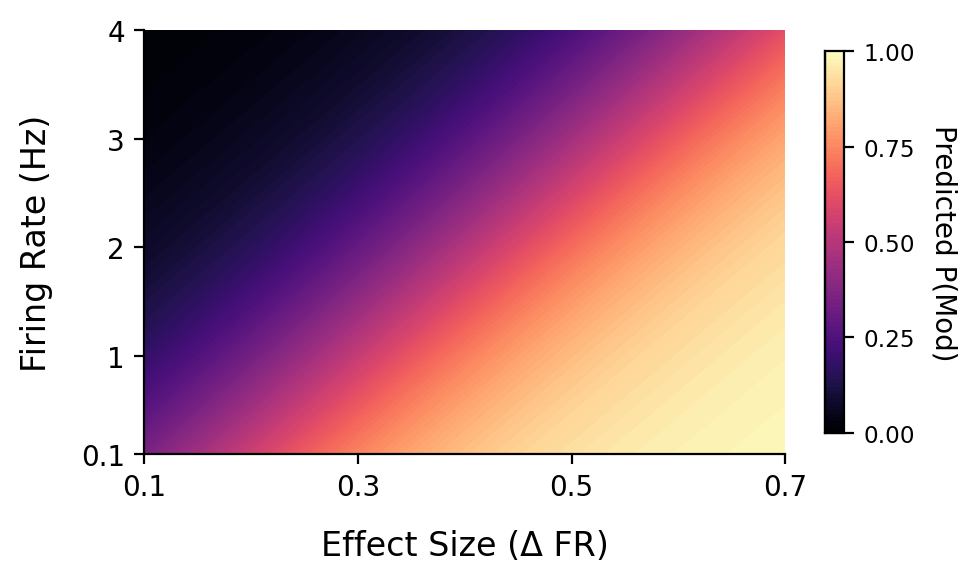

In [102]:
# 4) PLOT
plt.figure(figsize=(5,3))
cs = plt.contourf(delta_grid, lam_grid, proba, levels=100, cmap='magma')
cbar = plt.colorbar(cs, pad=0.05, shrink=0.9)
cbar.ax.tick_params(labelsize='small')
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_label('Predicted P(Mod)', rotation=270, labelpad=15, fontsize='medium')

plt.yticks([0.1, 1, 2, 3, 4], ['0.1', '1', '2', '3', '4'], fontsize='medium')
plt.xticks(np.arange(0.1, 0.9, 0.2), ['0.1', '0.3', '0.5', '0.7'], fontsize='medium')
plt.ylim(0.1, 4)
plt.xlim(0.1, 0.7)
plt.ylabel('Firing Rate (Hz)', fontsize = 'large', labelpad = 10)
plt.xlabel('Effect Size (Δ FR)', fontsize = 'large', labelpad = 10)
sns.despine(top=True, right=True)
plt.tight_layout()

# Export & Display
if export:
    plt.savefig((os.path.join(results_path, 'Group', 'Figures', 'ModProba.pdf')), dpi = 1200, bbox_inches = 'tight')
plt.show()